# Partitioning Algorithm 
### Estimating $E_0$ and $R_{eco, ref}$ values for the NEE model based on the following equations:
#### Night-time Model ([Reichstein 2005])
#### $$NEE_{night} = R_{eco} = R_{eco,ref}e^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 
#### Day-time Model (Lasslop et al., 2010)
#### $$NEE_{day}=\frac{\alpha \beta R_g}{\alpha R_g + \beta} + \gamma$$


In [37]:
from IPython.display import display, Math, Latex
import pandas as pd
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Flux Data Loading

In [16]:
flux_data_path = "complete_data.parquet"
flux_data = pd.read_parquet(flux_data_path)

In [17]:
for col in flux_data.columns:
    flux_data[col] = flux_data[col].replace(-9999, np.nan)

## Night Time Model

In [18]:
flux_data = flux_data[flux_data['Day/Night'] == False].reset_index(drop=True)

In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Lloyd-Taylor model function
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

# Step 1: Filter the data for night-time conditions
def filter_nighttime_data(df, radiation_threshold=10):
    night_data = df[df['Rg'] < radiation_threshold]
    return night_data

# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def filter_temperature_and_consecutive_periods(night_data, get_seq = False, temperature_column='Ta', min_data_points=6, window_size=88, temperature_range_threshold=5):

    valid_windows = []
    
    # Sort the DataFrame by the Datetime column
    night_data = night_data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    night_data['TimeDiff'] = night_data['DateTime'].diff()
    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    night_data['window_id'] = (night_data['TimeDiff'] > pd.Timedelta(hours=2)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    night_data = night_data.drop(columns=['TimeDiff'])

    for window_id, window in night_data.groupby("window_id"):
        temp_range = window[temperature_column].max() - window[temperature_column].min()
        if temp_range > temperature_range_threshold and len(window) >= min_data_points:
            valid_windows.append(window)

    # Combine all valid windows back into a single DataFrame
    if valid_windows:
        valid_windows_df = pd.concat(valid_windows).reset_index(drop=True)
    else:
        valid_windows_df = pd.DataFrame()

    if get_seq:
        return valid_windows
    return valid_windows_df

def estimate_E0_rb(valid_windows, temperature_column='Ta', reco_column='TER'):
    def objective_function(T, Reco_ref, E0):
        return lloyd_taylor(T, Reco_ref, E0)
    
    # Store the regression results
    regression_results = []

    # Perform regression for each valid period
    for window_id, window in valid_windows.groupby('window_id'):
        try:
            p0 = np.hstack((3 * np.ones((window.shape[0], 1)), 450 * np.ones((window.shape[0], 1))))

            popt, pcov = curve_fit(objective_function, window[temperature_column], window[reco_column], maxfev=10000)
            Reco_ref, E0 = popt
            std_error_E0 = np.sqrt(np.diag(pcov))[1]  # Standard error of E0
            std_error_recoref = np.sqrt(np.diag(pcov))[0]
            
            # Calculate residuals
            residuals = window[reco_column] - objective_function(window[temperature_column], Reco_ref, E0)
            residual_sum_of_squares = np.sum(residuals**2)
            
            regression_results.append((E0, Reco_ref, std_error_E0, std_error_recoref, residual_sum_of_squares, window_id))
        except:
            continue

    # Sort by standard error and residual sum of squares, and select the three best estimates
    #regression_results.sort(key=lambda x: (x[2], x[4]))
    regression_results.sort(key=lambda x: x[4])

    best_E0s = [result[0] for result in regression_results[:3]]
    best_recorefs = [result[1] for result in regression_results[:3]]
    best_residuals = [result[4] for result in regression_results[:3]]
    best_windows = [result[5] for result in regression_results[:3]]

    # Average the best three E0 values
    output = best_E0s, best_recorefs, best_residuals, best_windows
    
    return output


# Step 3: Estimate E0 using Lloyd-Taylor model regression with residual analysis
def estimate_E0(valid_windows, temperature_column='Ta', reco_column='TER'):
    def objective_function(T, Reco_ref, E0):
        return lloyd_taylor(T, Reco_ref, E0)
    
    # Store the regression results
    regression_results = []

    # Perform regression for each valid period
    for window_id, window in valid_windows.groupby('window_id'):
        try:
            p0 = np.hstack((3 * np.ones((window.shape[0], 1)), 450 * np.ones((window.shape[0], 1))))

            popt, pcov = curve_fit(objective_function, window[temperature_column], window[reco_column], maxfev=10000)
            Reco_ref, E0 = popt
            std_error_E0 = np.sqrt(np.diag(pcov))[1]  # Standard error of E0
            std_error_recoref = np.sqrt(np.diag(pcov))[0]
            
            # Calculate residuals
            residuals = window[reco_column] - objective_function(window[temperature_column], Reco_ref, E0)
            residual_sum_of_squares = np.sum(residuals**2)
            
            regression_results.append((E0, std_error_E0, residual_sum_of_squares))
        except:
            continue

    # Sort by standard error and residual sum of squares, and select the three best estimates
    regression_results.sort(key=lambda x: (x[1], x[2]))

    best_E0s = [result[0] for result in regression_results[:3]]
    best_recorefs = [result[1] for result in regression_results[:3]]

    # Average the best three E0 values
    E0 = np.mean(best_E0s)
    
    return E0

# Step 4: Estimate Reco_ref using a 7-day sliding window
def estimate_Reco_ref(df, E0, temperature_column='Ta', reco_column='TER', window_size=7):
    df['Reco_ref'] = np.nan
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i + window_size]
        Reco_ref_mean = window[reco_column].mean()
        df.loc[df.index[i + window_size - 1], 'Reco_ref'] = Reco_ref_mean

    # Interpolate missing values
    df['Reco_ref'].interpolate(method='linear', inplace=True)
    return df['Reco_ref']

# Step 5: Partition the NEE into Reco and GPP
def partition_nee(df, E0, temperature_column='Ta'):
    df['Reco'] = lloyd_taylor(df[temperature_column], df['Reco_ref'], E0)
    df['GPP'] = df['NEE'] + df['Reco']
    return df[['Reco', 'GPP']]

In [27]:
night_data = filter_nighttime_data(flux_data)
valid_windows = filter_temperature_and_consecutive_periods(night_data)

output = estimate_E0_rb(valid_windows)
output

([11.92864294694341, 51.48663171700584, 175.3658830751061],
 [2.6996284350749122, 1.3982757051835693, 1.8655380777572608],
 [0.0009013377331274892, 0.0012288919051572059, 0.0012878347092428084],
 [2403, 1675, 609])

2403 2019-01-19T18:30:00.000000000 2.6996284350749122 11.92864294694341


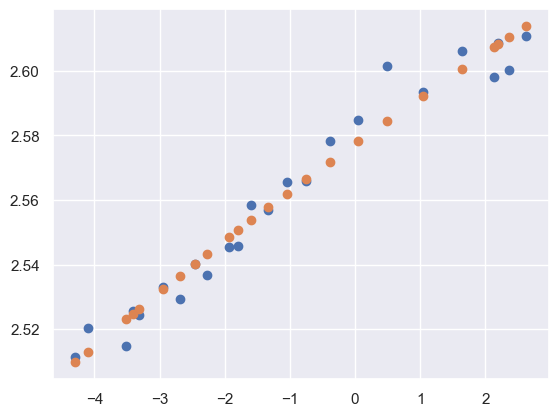

In [31]:
window_id = output[3][0]
rb = output[1][0]
e0 = output[0][0]


window = valid_windows[valid_windows["window_id"] == window_id]

plt.scatter(window["Ta"], window["TER"])
y = lloyd_taylor(window["Ta"], rb, e0)
plt.scatter(window["Ta"], y)

print(window_id, window["DateTime"].values[0], rb, e0)

609 2014-02-20T18:30:00.000000000 1.8655380777572608 175.3658830751061


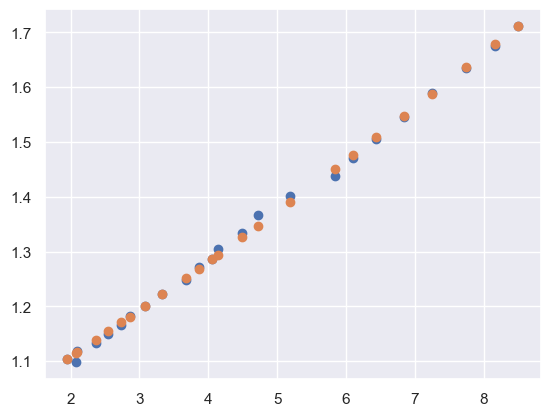

In [32]:
window_id = output[3][-1]
rb = output[1][-1]
e0 = output[0][-1]


window = valid_windows[valid_windows["window_id"] == window_id]

plt.scatter(window["Ta"], window["TER"])
y = lloyd_taylor(window["Ta"], rb, e0)
plt.scatter(window["Ta"], y)

print(window_id, window["DateTime"].values[0], rb, e0)

In [69]:
# Example usage:
# Assuming `df` is a pandas DataFrame containing columns: 'temperature', 'radiation', 'Reco', and 'NEE'

# Step 1: Filter for night-time data
# night_data = filter_nighttime_data(flux_data)

# Step 2: Filter for temperature and consecutive periods
night_data = flux_data.copy()
valid_windows = filter_temperature_and_consecutive_periods(night_data)


# Step 3: Estimate E0
E0 = estimate_E0(valid_windows)

# Step 4: Estimate Reco_ref
flux_data['Reco_ref'] = estimate_Reco_ref(flux_data, E0)

# Step 5: Partition the NEE
output = partition_nee(flux_data, E0)

# df now contains the 'Reco' and 'GPP' columns as the results of the partitioning.

In [70]:
E0

149.1497752455501

In [54]:
output

,Reco,GPP
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
65128,0.490599,NaN
65129,0.492439,NaN
65130,0.494422,NaN
65131,0.503748,NaN


## Day Model

In [34]:
day_data = flux_data[flux_data['Day/Night'] == True].reset_index(drop=True)

In [35]:
day_data = day_data.dropna(subset=["Rg"]).reset_index(drop=True)

In [38]:
day_data["E0"] = np.zeros(day_data.shape[0])

for date, indices in tqdm(day_data.groupby("Date").indices.items()):
    e0 = final_night_data["E0"][final_night_data["Date"] == date].values[0]
    day_data.loc[indices, "E0"] = e0
    
    

0it [00:00, ?it/s]


In [ ]:
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

# Light-response curve function for GPP
def light_response_curve(PAR, alpha, beta):
    return (alpha * beta * PAR) / (alpha * PAR + beta)


def fit_light_response_curve(day_data, PAR_column='Rg', nee_column='NEE_filled', temperature_column='Ta'):

    E0 = np.nan
    def combined_model(X, alpha, beta, Reco_ref):
        Rg = X["Rg"]
        T = X["Ta"]
        Reco = lloyd_taylor(T.values, Reco_ref, E0)
        GPP = light_response_curve(Rg.values, alpha, beta)
        return -(GPP - Reco)

    # Store the regression results
    regression_results = []

    output = day_data.copy()
    output["alpha"] = np.zeros(output.shape[0])
    output["beta"] = np.zeros(output.shape[0])
    output["rb"] = np.zeros(output.shape[0])
    
    # Perform regression for each valid period
    for window_id, window in day_data.groupby('window_id'):
            
        E0 = window["E0"].values[0]
        
        popt, _ = curve_fit(combined_model, window[[PAR_column, temperature_column]], window[nee_column], maxfev=10000)
        alpha, beta, Reco_ref = popt
        
        output.loc[output["window_id"] == window_id, "rb"] = Reco_ref
        output.loc[output["window_id"] == window_id, "alpha"] = alpha
        output.loc[output["window_id"] == window_id, "beta"] = beta

    return output


# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def generate_day_sequences(data, get_seq = False):
    
    # Sort the DataFrame by the Datetime column
    data = data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    data['TimeDiff'] = data['DateTime'].diff()

    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    data['window_id'] = (data['TimeDiff'] > pd.Timedelta(hours=4)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    data = data.drop(columns=['TimeDiff'])

    return data



In [ ]:
valid_windows = generate_day_sequences(day_data)
# Step 2: Fit the light-response curve for day-time data
output = fit_light_response_curve(valid_windows)